# Gym Planner

In [1]:
import numpy as np
import pandas as pd
import re
from urllib.request import urlopen
from bs4 import BeautifulSoup

%matplotlib inline

print('everything imported')


everything imported


## Part1: We will first grab data from wikipedia on Bay area counties, cities etc

In [2]:

#creating URL
url = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_the_San_Francisco_Bay_Area"
html = urlopen(url)

#making the soup
soup = BeautifulSoup(html, 'lxml')



Next we will extract the data 

In [3]:
#getting the table we need plainrowheaders.sortable.jquery-tablesorter , {'class':'wikitable '})
tables = soup.find_all('table')

table = tables[1]

#Pulling the rows we need

for row in table:
    tr_rows = table.find_all('tr')
                        


data_list = []

for row in tr_rows:
    td_rows = row.find_all('td')
    str_cells = str(td_rows)
    cleantext = BeautifulSoup(str_cells, "lxml").get_text()
    data_list.append(cleantext)
    

print('we have our row data!')

we have our row data!


Now we will build our dataframe

In [4]:
df = pd.DataFrame(data_list)
#Split up Dataframe
df = df[0].str.split(',', expand=True)
#drop some useless rows
df.drop({0,1}, inplace=True)
#reset the index
df.reset_index(drop=True, inplace=True)


data_list1 = []

for row in table:
    tr_head = table.find_all('th')
    str_cells1 = str(tr_head)
    tr_head_clean = BeautifulSoup(str_cells1, "lxml").get_text()
    data_list1.append(tr_head_clean)
    
    
    

print('we have our  full data!')
                        



we have our  full data!


We will now formate and clean the data to creat a clean dataframe

In [5]:
df1 = pd.DataFrame(data_list1)
#Split up Dataframe
df1 = df1[0].str.split(',', expand=True)
#transpose 
df1_transposed = df1.T

#remove rows we dont need
df1_transposed.drop({0,1,2,3,4,5,6,7}, inplace=True)

#reindex
df1_transposed.reset_index(drop=True, inplace=True)


#merge to df toghether headers and data
df_new = pd.concat([df1_transposed, df], axis=1, sort=False)

#add column names
df_new.columns = ['City' , 'City_Name', 'Type', 'County', 'PopA', 'PopB', 'Miles', 'Land Area Km', 'IncA', 'IncB']
#drop useless columns
df_new.drop(['IncA', 'IncB', 'Miles', 'Type'], axis=1, inplace=True)


#do some type casting
df_new['Pop'] = df_new['PopA'].astype(float).mul(1000) + df_new['PopB'].astype(float)
df_new.drop(['PopA','PopB'], axis=1, inplace=True)



# do some striping
df_new['County'] = df_new['County'].str.strip('\n')
df_new['City'] = df_new['City'].str.strip('\n')
df_new['City_Name'] = df_new['City_Name'].str.strip('\n')
df_new['Land Area Km'] = df_new['Land Area Km'].str.strip('\n')
                           
#bit more casting
df_new['Land Area Km'] = df_new['Land Area Km'].astype(float)



We Now have an extracted cleaned data set of which cities are in which counties in the Bay Area

In [69]:
print(df_new.shape)
df_new.head(5)

(101, 5)


,City,City_Name,County,Land Area Km,Pop
0,Alameda,Alameda,Alameda,27.5,73812.0
1,Albany,Albany,Alameda,4.6,18539.0
2,American Canyon,American Canyon,Napa,12.5,19454.0
3,Antioch,Antioch,Contra Costa,73.4,102372.0
4,Atherton,Atherton,San Mateo,13.0,6914.0


# Part 2:  Grabbing Data from Zip code.csv of CA and creating a merged datframe of Cities and their Zip codes in the Bay Area

In [77]:
# getting the .csv file of zip code data

pcode = pd.read_csv('us-zip-code-latitude-and-longitude.csv', sep= ';').copy()

#Srip the white space from both dataframes

pcode['City'] = pcode['City'].str.strip().copy()

df_new['City'] = df_new['City'].str.strip().copy()

#merge tha Data
combo_df = pd.merge(df_new, pcode, how='outer', on= 'City').copy()


#drop rows outside Bay Area
filter_df = combo_df.dropna().copy()


#lets clean up 

filter_df['Zip'] = filter_df['Zip'].astype(int)
filter_df['Pop'] = filter_df['Pop'].astype(int)


#Lets drop some columns we wont need
filter_df.drop(['City_Name', 'State', 'Timezone', 'Daylight savings time flag', 'geopoint'], axis=1, inplace=True)

#set index
filter_df.set_index('Zip', inplace=True)


### We now have a combo DataFrame called zip_df for Bay Area 

In [78]:
#Make a copy of DF so that its easier to remember the name
Zip_df = filter_df
print('Zip DataFrame: ', Zip_df.shape)
Zip_df.head(5)


Zip DataFrame:  (403, 6)


,City,County,Land Area Km,Pop,Latitude,Longitude
Zip,,,,,,
94501,Alameda,Alameda,27.5,73812,37.769528,-122.25937
94502,Alameda,Alameda,27.5,73812,37.734379,-122.23952
94706,Albany,Alameda,4.6,18539,37.889125,-122.29371
94503,American Canyon,Napa,12.5,19454,38.170372,-122.25605
94509,Antioch,Contra Costa,73.4,102372,37.991571,-121.80207


# Part 3:  Extracting Census Data and building features datasets


First the commuter Data

In [79]:
#Lets start with  the commute data

Com_df = pd.read_csv('commute.csv')

#drop the fields we dont need 

Com_df.drop(['geoid'], axis=1, inplace=True)

#set Zip as Index
Com_df.set_index('Zip', inplace=True)


print(Com_df.shape)
print(Zip_df.shape)

(1775, 11)
(403, 6)


In [80]:
#merging DataFrames
comzip_df = pd.merge(Com_df, Zip_df, right_index=True, left_index=True)
print(comzip_df.shape)


(222, 17)


the Dataframe is smaller as census picked most central zip code of smaller cities and discarded others

Income Data

In [81]:
#Lets get the Income data

Income_df = pd.read_csv('IncomeRange.csv')

#drop the fields we dont need 

Income_df.drop(['geoid'], axis=1, inplace=True)

#set Zip as Index
Income_df.set_index('Zip', inplace=True)


print(Income_df.shape)
print(Zip_df.shape)



(1775, 17)
(403, 6)


In [82]:
#merging DataFrames
inczip_df = pd.merge(Income_df, Zip_df, right_index=True, left_index=True)
print(inczip_df.shape)



(222, 23)


Getting Age Range

In [83]:
#Lets get the Age data

age_df = pd.read_csv('AgeRange.csv')

#drop the fields we dont need 

age_df.drop(['geoid'], axis=1, inplace=True)

#set Zip as Index
age_df.set_index('Zip', inplace=True)


print(age_df.shape)
print(Zip_df.shape)


(1775, 49)
(403, 6)


In [84]:
#merging DataFrames
agezip_df = pd.merge(age_df, Zip_df, right_index=True, left_index=True)
print(agezip_df.shape)


(222, 55)


Finally Getting own/rent Data

In [85]:
#Lets get the Age data

own_df = pd.read_csv('ownrent.csv')

#drop the fields we dont need 

own_df.drop(['geoid'], axis=1, inplace=True)

#set Zip as Index
own_df.set_index('Zip', inplace=True)


print(own_df.shape)
print(Zip_df.shape)


(1775, 3)
(403, 6)


In [86]:
#merging DataFrames
ownzip_df = pd.merge(own_df, Zip_df, right_index=True, left_index=True)
print(ownzip_df.shape)
ownzip_df.head()

(222, 9)


,Total,Owned,Rent,City,County,Land Area Km,Pop,Latitude,Longitude
Zip,,,,,,,,,
94002,10380,6308,4072,Belmont,San Mateo,12.0,25835,37.516687,-122.29026
94005,1836,1354,482,Brisbane,San Mateo,8.0,4282,37.682882,-122.40422
94010,16037,9460,6577,Burlingame,San Mateo,11.4,28806,37.574936,-122.36332
94014,14028,8169,5859,Daly City,San Mateo,19.8,101123,37.699182,-122.45035
94015,20052,11199,8853,Daly City,San Mateo,19.8,101123,37.682583,-122.48209


## We now have 4 datasets with Zip codes and lat/longs comzip_df, agezip_df, inczip_df, and ownzip_df

# Part 4  Getting our Foursquare Data

In [88]:
# Cell with creds hidden due to security

In [89]:
#Function for extracting the venue data
import requests # library to handle requests
RADIUS = '1000'
CATEGORY ='4bf58dd8d48988d175941735'



def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
      
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS,
            CATEGORY)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['id'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude','Category1',         
                  'Venue Category']
                  #'Venue Postal Code']
    
    return(nearby_venues)

### We will use agezip as a  dataset  with zip and lat long to retrieve  foursquare data

In [149]:

gym_venues = getNearbyVenues(names=agezip_df['City'],
                                   latitudes=agezip_df['Latitude'],
                                   longitudes=agezip_df['Longitude']
                                  )

gym_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Category1,Venue Category
0,Belmont,37.516687,-122.29026,Yvonne and Schuyler Moore Athletic Pavilion,37.515504,-122.285230,4bf58dd8d48988d176941735,Gym
1,Belmont,37.516687,-122.29026,United Studios of Self Defense,37.511324,-122.292948,4bf58dd8d48988d101941735,Martial Arts Dojo
2,Burlingame,37.574936,-122.36332,Ludus Fitness LLC,37.567474,-122.367654,4bf58dd8d48988d175941735,Gym / Fitness Center
3,Daly City,37.699182,-122.45035,Pointe Pacific Gym,37.701279,-122.456457,4bf58dd8d48988d176941735,Gym
4,Daly City,37.682583,-122.48209,Westmoor High School Track,37.680401,-122.479619,4bf58dd8d48988d106941735,Track


In [150]:
gym_venues.shape


(1611, 8)

### We have a data frame of all Gyms in the Bay area

# Lets work out what fitness classes we have

In [250]:
orange_df = gym_venues[gym_venues["Venue"].str.contains("Orange", case=False)].copy()

print('The number of Orange Theories is', len(orange_df.index))
orange_df['Orange'] = '1'


The number of Orange Theories is 30


In [251]:
cycle_df = gym_venues[gym_venues["Venue Category"].str.contains("Cycle Studio", case=False)].copy()
print('The number of Cycle studios  is', len(cycle_df.index))
cycle_df['Cycle'] = "1"


The number of Cycle studios  is 13


In [252]:
pilates_df = gym_venues[gym_venues["Venue"].str.contains("Pilates", case=False)].copy()
print('The number of Pilates Studios is', len(pilates_df.index))
pilates_df['pilates'] = "1"


The number of Pilates Studios is 54


In [253]:
crossfit_df = gym_venues[gym_venues["Venue"].str.contains("Crossfit", case=False)].copy()
print('The number of CrossFit Gyms is', len(crossfit_df.index))
crossfit_df['crossfit'] = "1"


The number of CrossFit Gyms is 41


In [254]:
yoga_df = gym_venues[gym_venues["Venue Category"].str.contains("Yoga", case=False)].copy()
print('The number of Yoga Studios is', len(yoga_df.index))
yoga_df['yoga'] = "1"


The number of Yoga Studios is 194


### Lets Create a Visual

In [58]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
from geopy.geocoders import Nominatim
import json

In [207]:
# Get Coordinates for San Francisco
address = 'San Francisco , California'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of San Francisco are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of San Francisco are 37.7790262, -122.4199061.


In [1361]:
# create map of Bay Area using latitude and longitude values
map_bay = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers for Yoga  
    
for lat, lng, venue in zip(yoga_df['Venue Latitude'], yoga_df['Venue Longitude'], yoga_df['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='green', prefix= 'fa' , icon = 'circle')).add_to(map_bay)  
    

# add markers to map for Orange Theory
for lat, lng, venue in zip(orange_df['Venue Latitude'], orange_df['Venue Longitude'], orange_df['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='orange', prefix= 'fa' , icon = 'circle')).add_to(map_bay)  
    
# add markers for Pilates    
    
for lat, lng, venue in zip(pilates_df['Venue Latitude'], pilates_df['Venue Longitude'], pilates_df['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='blue', prefix= 'fa' , icon = 'circle')).add_to(map_bay)  

    
# add markers for Crossfit    
    
for lat, lng, venue in zip(crossfit_df['Venue Latitude'], crossfit_df['Venue Longitude'], crossfit_df['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='red', prefix= 'fa' , icon = 'circle')).add_to(map_bay)  
    
# add markers for Cycle    
    
for lat, lng, venue in zip(cycle_df['Venue Latitude'], cycle_df['Venue Longitude'], cycle_df['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='yellow', prefix= 'fa' , icon = 'circle')).add_to(map_bay)  
    
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 200px; height: 150px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">
                              &nbsp; Orange Theory &nbsp; <i class="fa fa-map-marker fa-2x" style="color:orange"></i><br>
                              &nbsp; Yoga Studio &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                              &nbsp; Pilates Studio &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
                              &nbsp; Crossfit &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i><br>
                              &nbsp; Cycle &nbsp; <i class="fa fa-map-marker fa-2x" style="color:yellow"></i>
                </div>
                ''' 
map_bay.get_root().html.add_child(folium.Element(legend_html))
    
map_bay

# Part 5 Combining all the Gym locations into a matrix so we can start classfifying the data

In [679]:
#use agezip and orange as the starting point

combozip_df = agezip_df.reset_index().merge(orange_df, left_on= 'Latitude', right_on= 'Neighborhood Latitude').set_index(agezip_df.index.names)

#combozip_df.shape
#combozip_df.head()

combozip_df = combozip_df[['Venue','Orange']].copy()


In [680]:
#adding Yoga

yogazip_df = agezip_df.reset_index().merge(yoga_df, left_on= 'Latitude', right_on= 'Neighborhood Latitude').set_index(agezip_df.index.names)

yogazip_df = yogazip_df[['Venue','yoga']].copy()


combozip_df = pd.merge(combozip_df, yogazip_df, left_index=True, right_index=True, how= 'outer')




In [681]:
#Adding Crossfit

crossfitzip_df = agezip_df.reset_index().merge(crossfit_df, left_on= 'Latitude', right_on= 'Neighborhood Latitude').set_index(agezip_df.index.names)

crossfitzip_df = crossfitzip_df[['Venue','crossfit']].copy()


combozip_df = pd.merge(combozip_df, crossfitzip_df, left_index=True, right_index=True, how= 'outer')




In [682]:
#Adding Pilates

pilateszip_df = agezip_df.reset_index().merge(pilates_df, left_on= 'Latitude', right_on= 'Neighborhood Latitude').set_index(agezip_df.index.names)

pilateszip_df = pilateszip_df[['Venue','pilates']].copy()


combozip_df = pd.merge(combozip_df, pilateszip_df, left_index=True, right_index=True, how= 'outer')

#tcombozip_df.head()


In [683]:
#Adding Cycle

cyclezip_df = agezip_df.reset_index().merge(cycle_df, left_on= 'Latitude', right_on= 'Neighborhood Latitude').set_index(agezip_df.index.names)

cyclezip_df = cyclezip_df[['Venue','Cycle']].copy()


combozip_df = pd.merge(combozip_df, cyclezip_df, left_index=True, right_index=True, how= 'outer')



In [684]:
combozip_df.head()

,Venue_x,Orange,Venue_y,yoga,Venue_x,crossfit,Venue_y,pilates,Venue,Cycle
Zip,,,,,,,,,,
94022,NaN,NaN,Yoga of Los Altos,1,NaN,NaN,Evolve Classical Pilates,1,NaN,NaN
94022,NaN,NaN,Yoga of Los Altos,1,NaN,NaN,Empowered Body Pilates,1,NaN,NaN
94025,NaN,NaN,Yogarock Living,1,NaN,NaN,NaN,NaN,NaN,NaN
94030,NaN,NaN,Grace Yoga,1,NaN,NaN,NaN,NaN,Rush Cycle - Millbrae,1
94040,NaN,NaN,California Yoga Center,1,NorCal Crossfit Mountain View,1,NaN,NaN,NaN,NaN


In [685]:
combozip_df.shape

(278, 10)

We can see from this that we have 68 Zip codes with more than 1 of a type of gym e.g 2 yoga studios so we will need to clean the data and then somehow make a decision about which to use


In [686]:
# drop the venue names as we no longer need them

combozip_df = combozip_df[['Orange', 'yoga', 'crossfit', 'pilates', 'Cycle']]

combozip_df.head()

,Orange,yoga,crossfit,pilates,Cycle
Zip,,,,,
94022,NaN,1,NaN,1,NaN
94022,NaN,1,NaN,1,NaN
94025,NaN,1,NaN,NaN,NaN
94030,NaN,1,NaN,NaN,1
94040,NaN,1,1,NaN,NaN


In [687]:
# turn thos NaN's into 0's

combozip_df['Orange'] = combozip_df['Orange'].fillna(0).astype(int)
combozip_df['yoga'] = combozip_df['yoga'].fillna(0).astype(int)
combozip_df['crossfit'] = combozip_df['crossfit'].fillna(0).astype(int)
combozip_df['pilates'] = combozip_df['pilates'].fillna(0).astype(int)
combozip_df['Cycle'] = combozip_df['Cycle'].fillna(0).astype(int)


combozip_df.head()


,Orange,yoga,crossfit,pilates,Cycle
Zip,,,,,
94022,0,1,0,1,0
94022,0,1,0,1,0
94025,0,1,0,0,0
94030,0,1,0,0,1
94040,0,1,1,0,0


So now we need a classification so we will use the following

Going to test what our classes look like

In [688]:
#first we will create a sum column so we can work out number of Multi Categories
combozip_df['thesum'] = combozip_df['Orange'] + combozip_df['yoga'] +  combozip_df['crossfit'] + combozip_df['pilates'] + combozip_df['Cycle']
combozip_df.head()

,Orange,yoga,crossfit,pilates,Cycle,thesum
Zip,,,,,,
94022,0,1,0,1,0,2
94022,0,1,0,1,0,2
94025,0,1,0,0,0,1
94030,0,1,0,0,1,2
94040,0,1,1,0,0,2


In [689]:
#sorting the Data and working out the 4 Category combinations
combozip_df.sort_values(by=['thesum', 'Orange','yoga', 'crossfit', 'pilates', 'Cycle'], ascending=False, inplace=True)
combozip_df.head(5)

,Orange,yoga,crossfit,pilates,Cycle,thesum
Zip,,,,,,
94102,1,1,1,1,0,4
94549,1,1,1,1,0,4
94549,1,1,1,1,0,4
94703,1,1,1,1,0,4
94703,1,1,1,1,0,4


In [690]:
# Working out the 3 Factor Categories
threefactor_df = combozip_df[combozip_df['thesum'] == 3] 

threefactor_df.shape


threefactor_df.head(5)

,Orange,yoga,crossfit,pilates,Cycle,thesum
Zip,,,,,,
94104,1,1,1,0,0,3
94105,1,1,1,0,0,3
94111,1,1,1,0,0,3
94111,1,1,1,0,0,3
94401,1,1,1,0,0,3


Lets now add these Categories to our DataSet

In [691]:
#factor_df = combozip_df['thesum'][(combozip_df['thesum'] == 3)]
threefactor_df = combozip_df[combozip_df['thesum'] == 3] 

threefactor_df.shape


(60, 6)

### We now use our algorythm to classify the data

In [802]:
#Single Categories
combozip_df.loc[combozip_df['Orange'] > 0, 'Category'] = 'Or'
combozip_df.loc[combozip_df['yoga'] > 0, 'Category'] = 'Yo'
combozip_df.loc[combozip_df['crossfit'] > 0, 'Category'] = 'Cr'
combozip_df.loc[combozip_df['pilates'] > 0, 'Category'] = 'Pi'
combozip_df.loc[combozip_df['Cycle'] > 0, 'Category'] = 'Cy'

In [803]:
#Double Categories

combozip_df.loc[(combozip_df['thesum'] == 2) & (combozip_df['Orange'] == 1) & (combozip_df["yoga"] == 1), 'Category'] = 'OrYo'
combozip_df.loc[(combozip_df['thesum'] == 2) & (combozip_df['Orange'] == 1) & (combozip_df["crossfit"] == 1), 'Category'] = 'OrCr'
combozip_df.loc[(combozip_df['thesum'] == 2) & (combozip_df['Orange'] == 1) & (combozip_df["pilates"] == 1), 'Category'] = 'OrPi'
combozip_df.loc[(combozip_df['thesum'] == 2) & (combozip_df['Orange'] == 1) & (combozip_df["Cycle"] == 1), 'Category'] = 'OrCy'

combozip_df.loc[(combozip_df['thesum'] == 2) & (combozip_df['yoga'] == 1) & (combozip_df["crossfit"] == 1), 'Category'] = 'YoCr'
combozip_df.loc[(combozip_df['thesum'] == 2) & (combozip_df['yoga'] == 1) & (combozip_df["pilates"] == 1), 'Category'] = 'YoPi'
combozip_df.loc[(combozip_df['thesum'] == 2) & (combozip_df['yoga'] == 1) & (combozip_df["Cycle"] == 1), 'Category'] = 'YoCy'

combozip_df.loc[(combozip_df['thesum'] == 2) & (combozip_df['crossfit'] == 1) & (combozip_df["pilates"] == 1), 'Category'] = 'CrPi'
combozip_df.loc[(combozip_df['thesum'] == 2) & (combozip_df['crossfit'] == 1) & (combozip_df["Cycle"] == 1), 'Category'] = 'CrCy'

combozip_df.loc[(combozip_df['thesum'] == 2) & (combozip_df['pilates'] == 1) & (combozip_df["Cycle"] == 1), 'Category'] = 'PiCy'



In [804]:
#Treble Categories
combozip_df.loc[(combozip_df['thesum'] == 3) & (combozip_df['Orange'] == 1) & (combozip_df["yoga"] == 1) & (combozip_df["crossfit"] == 1), 'Category'] = 'OrYoCr'
combozip_df.loc[(combozip_df['thesum'] == 3) & (combozip_df['Orange'] == 1) & (combozip_df["yoga"] == 1) & (combozip_df["pilates"] == 1), 'Category'] = 'OrYoPi'
combozip_df.loc[(combozip_df['thesum'] == 3) & (combozip_df['yoga'] == 1) & (combozip_df["crossfit"] == 1) & (combozip_df["pilates"] == 1), 'Category'] = 'YoCrPi'
combozip_df.loc[(combozip_df['thesum'] == 3) & (combozip_df['yoga'] == 1) & (combozip_df["crossfit"] == 1) & (combozip_df["Cycle"] == 1), 'Category'] = 'YoCrCy'
combozip_df.loc[(combozip_df['thesum'] == 3) & (combozip_df['yoga'] == 1) & (combozip_df["pilates"] == 1) & (combozip_df["Cycle"] == 1), 'Category'] = 'YoPiCy'




In [805]:
#Quadruple Categories

combozip_df.loc[(combozip_df['thesum'] == 4) & (combozip_df['Orange'] == 1) & (combozip_df["yoga"] == 1) & (combozip_df["crossfit"] == 1) & (combozip_df["pilates"] == 1), 'Category'] = 'OrYoCrPi'
combozip_df.loc[(combozip_df['thesum'] == 4) & (combozip_df['yoga'] == 1) & (combozip_df["crossfit"] == 1) & (combozip_df["pilates"] == 1) & (combozip_df["Cycle"] == 1), 'Category'] = 'YoCrPiCy'

In [1362]:
combozip_df.reset_index()
combozip_df.head(5)

,Orange,yoga,crossfit,pilates,Cycle,thesum,Category
Zip,,,,,,,
94102,1,1,1,1,0,4,OrYoCrPi
94549,1,1,1,1,0,4,OrYoCrPi
94549,1,1,1,1,0,4,OrYoCrPi
94703,1,1,1,1,0,4,OrYoCrPi
94703,1,1,1,1,0,4,OrYoCrPi


In [807]:
combozip_df.shape


(278, 7)

In [997]:
#Remove index so we can dedupe

Ncombozip_df = combozip_df.copy()

Ncombozip_df.reset_index(level=0, inplace=True)
Ncombozip_df.head(5)

,Zip,Orange,yoga,crossfit,pilates,Cycle,thesum,Category
0,94102,1,1,1,1,0,4,OrYoCrPi
1,94549,1,1,1,1,0,4,OrYoCrPi
2,94549,1,1,1,1,0,4,OrYoCrPi
3,94703,1,1,1,1,0,4,OrYoCrPi
4,94703,1,1,1,1,0,4,OrYoCrPi


In [999]:
#dedupe
Ncombozip_df = Ncombozip_df.drop_duplicates()
Ncombozip_df.shape

(116, 8)

In [1000]:
Ncombozip_df.head()

,Zip,Orange,yoga,crossfit,pilates,Cycle,thesum,Category
0,94102,1,1,1,1,0,4,OrYoCrPi
1,94549,1,1,1,1,0,4,OrYoCrPi
3,94703,1,1,1,1,0,4,OrYoCrPi
15,94110,0,1,1,1,1,4,YoCrPiCy
23,94104,1,1,1,0,0,3,OrYoCr


In [1001]:
#reindex
Ncombozip_df.set_index(['Zip'], inplace= True)

In [1002]:
Ncombozip_df.head()

,Orange,yoga,crossfit,pilates,Cycle,thesum,Category
Zip,,,,,,,
94102,1,1,1,1,0,4,OrYoCrPi
94549,1,1,1,1,0,4,OrYoCrPi
94703,1,1,1,1,0,4,OrYoCrPi
94110,0,1,1,1,1,4,YoCrPiCy
94104,1,1,1,0,0,3,OrYoCr


So we now have Ncombozip_df which is a DF containing all the foursquare data we need to begin analysis  116 of 222 Xip codes in California have one of our gym types


# Part 6:   Merging the data and looking for significant features

### Let's start with the Age Group data

In [815]:
#Lets make a copy of our Dataframe to operate on
Nagezip_df = agezip_df.copy()

#calculate Male  %
Nagezip_df['Male Per'] = Nagezip_df['Male'] / Nagezip_df['Total']

#calculate % of People in Gym Going Age

Nagezip_df['Gym Age Per'] = (Nagezip_df.iloc[:, 10:17].sum(axis=1) + Nagezip_df.iloc[:, 35:42].sum(axis=1)) / Nagezip_df['Total']

#Have Kids younger than 4
Nagezip_df['Young Kids'] = (Nagezip_df['M 0-4'] + Nagezip_df['F 0-4']) / Nagezip_df['Total']

#Population Density

Nagezip_df['Density'] = (Nagezip_df['Total'] / Nagezip_df['Land Area Km']).astype(int)


#Skinny down our Dataframe to essential fields
Nagezip_df = Nagezip_df[{'City','Total','Land Area Km','Male Per','Gym Age Per', 'Young Kids', 'Density'}]
Nagezip_df.head()


,Male Per,Total,Gym Age Per,Young Kids,City,Density,Land Area Km
Zip,,,,,,,
94002,0.499228,27202,0.485405,0.061613,Belmont,2266,12.0
94005,0.471867,4692,0.518968,0.046675,Brisbane,586,8.0
94010,0.476457,42730,0.462368,0.056611,Burlingame,3748,11.4
94014,0.502878,49515,0.483550,0.047157,Daly City,2500,19.8
94015,0.488310,64887,0.482994,0.040825,Daly City,3277,19.8


In [816]:
# Merge in our Gym Data

Nagezip_df = pd.merge(Nagezip_df, Ncombozip_df, left_index=True, right_index=True, how= 'outer')
Nagezip_df.fillna(0, inplace= True)

Nagezip_df.head(20)

,Male Per,Total,Gym Age Per,Young Kids,City,Density,Land Area Km,Orange,yoga,crossfit,pilates,Cycle,thesum,Category
Zip,,,,,,,,,,,,,,
94002,0.499228,27202,0.485405,0.061613,Belmont,2266,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0
94005,0.471867,4692,0.518968,0.046675,Brisbane,586,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0
94010,0.476457,42730,0.462368,0.056611,Burlingame,3748,11.4,0.0,0.0,0.0,0.0,0.0,0.0,0
94014,0.502878,49515,0.483550,0.047157,Daly City,2500,19.8,0.0,0.0,0.0,0.0,0.0,0.0,0
94015,0.488310,64887,0.482994,0.040825,Daly City,3277,19.8,0.0,0.0,0.0,0.0,0.0,0.0,0
94019,0.475386,20314,0.460274,0.049621,Half Moon Bay,1223,16.6,0.0,0.0,0.0,0.0,0.0,0.0,0
94022,0.493033,19378,0.417381,0.027299,Los Altos,1153,16.8,0.0,1.0,0.0,1.0,0.0,2.0,YoPi
94024,0.471808,23961,0.429949,0.044405,Los Altos,1426,16.8,0.0,0.0,0.0,0.0,0.0,0.0,0
94025,0.476886,42788,0.460246,0.077335,Menlo Park,1684,25.4,0.0,1.0,0.0,0.0,0.0,1.0,Yo


We can plot a few regression plots



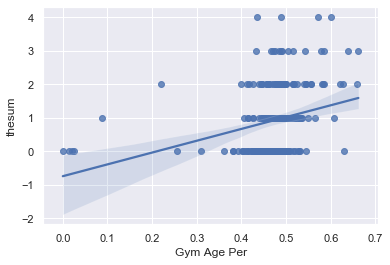

In [818]:
import seaborn as sns; sns.set(color_codes=True)
ax = sns.regplot(x="Gym Age Per", y="thesum", data= Nagezip_df)

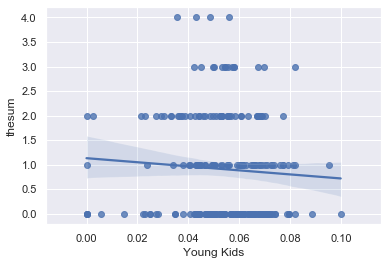

In [819]:
ax = sns.regplot(x="Young Kids", y="thesum", data= Nagezip_df)

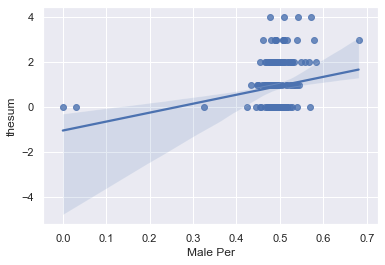

In [820]:
ax = sns.regplot(x="Male Per", y="thesum", data= Nagezip_df)

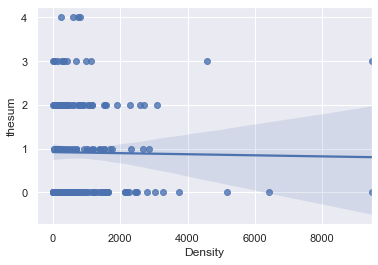

In [821]:
ax = sns.regplot(x="Density", y="thesum", data= Nagezip_df)

So it looks like Gym Age, Young kids and Male/Female all have significant features that we should use

## Use our Commuter Data


In [822]:
#copy dataframe for safety
Ncomzip_df =comzip_df.copy()
Ncomzip_df.head()

,Total,<10,10-14,15-19,20-24,25-29,30-34,35-44,45-59,>60,Car/Truck/Van,City,County,Land Area Km,Pop,Latitude,Longitude
Zip,,,,,,,,,,,,,,,,,
94002,12805,926,1394,1750,1523,894,1718,1462,1858,1280,11345,Belmont,San Mateo,12.0,25835,37.516687,-122.29026
94005,2340,186,41,235,224,164,314,404,500,272,1875,Brisbane,San Mateo,8.0,4282,37.682882,-122.40422
94010,19548,1432,2334,2712,2189,1143,2781,1956,2880,2121,15665,Burlingame,San Mateo,11.4,28806,37.574936,-122.36332
94014,26990,1171,2315,3204,4456,1300,5347,2316,3526,3355,19197,Daly City,San Mateo,19.8,101123,37.699182,-122.45035
94015,34311,2193,3228,5165,5213,2264,5900,2770,3724,3854,26937,Daly City,San Mateo,19.8,101123,37.682583,-122.48209


In [823]:
#Lets agregate our data into Short Medium and Long Commutes and Add % by Car

Ncomzip_df['Short Commute'] = Ncomzip_df.iloc[:, 1:4].sum(axis=1) / Ncomzip_df['Total']
Ncomzip_df['Medium Commute'] = Ncomzip_df.iloc[:, 4:8].sum(axis=1) / Ncomzip_df['Total']
Ncomzip_df['Long Commute'] = Ncomzip_df.iloc[:, 8:10].sum(axis=1) / Ncomzip_df['Total']
Ncomzip_df['Car Per'] = Ncomzip_df['Car/Truck/Van'] / Ncomzip_df['Total']

Ncomzip_df = Ncomzip_df[{'City', 'Short Commute','Medium Commute','Long Commute', 'Car Per'}]

Ncomzip_df.head()


,Long Commute,Medium Commute,Short Commute,City,Car Per
Zip,,,,,
94002,0.245061,0.437095,0.317845,Belmont,0.885982
94005,0.329915,0.472650,0.197436,Brisbane,0.801282
94010,0.255832,0.412779,0.331389,Burlingame,0.801361
94014,0.254946,0.497184,0.247870,Daly City,0.711263
94015,0.220862,0.470607,0.308531,Daly City,0.785084


In [824]:
Ncomzip_df = pd.merge(Ncomzip_df, Ncombozip_df, left_index=True, right_index=True, how= 'outer')
Ncomzip_df.fillna(0, inplace= True)



In [826]:
Nagezip_df.head(5)


,Male Per,Total,Gym Age Per,Young Kids,City,Density,Land Area Km,Orange,yoga,crossfit,pilates,Cycle,thesum,Category
Zip,,,,,,,,,,,,,,
94002,0.499228,27202,0.485405,0.061613,Belmont,2266,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0
94005,0.471867,4692,0.518968,0.046675,Brisbane,586,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0
94010,0.476457,42730,0.462368,0.056611,Burlingame,3748,11.4,0.0,0.0,0.0,0.0,0.0,0.0,0
94014,0.502878,49515,0.483550,0.047157,Daly City,2500,19.8,0.0,0.0,0.0,0.0,0.0,0.0,0
94015,0.488310,64887,0.482994,0.040825,Daly City,3277,19.8,0.0,0.0,0.0,0.0,0.0,0.0,0


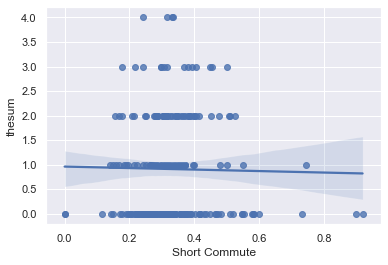

In [827]:
ax = sns.regplot(x="Short Commute", y="thesum", data= Ncomzip_df)

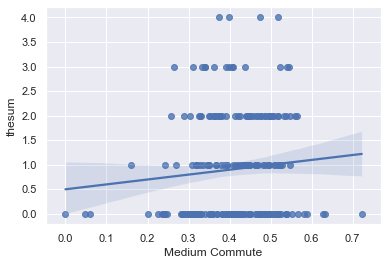

In [828]:
ax = sns.regplot(x="Medium Commute", y="thesum", data= Ncomzip_df)

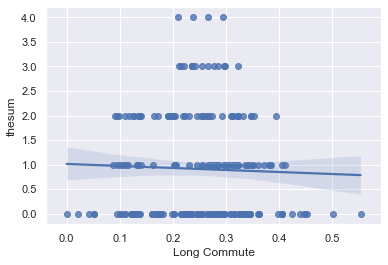

In [829]:
ax = sns.regplot(x="Long Commute", y="thesum", data= Ncomzip_df)

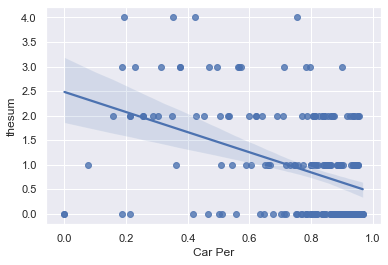

In [830]:
ax = sns.regplot(x="Car Per", y="thesum", data= Ncomzip_df)

The length of commute seem to be a good feature and we can use one feature so choosing Long commute.  Also the % of people that commute by car is inversely proportional to gyms

### Lets use income data

In [838]:
Ninczip_df = inczip_df.copy()
Ninczip_df.head()

,Total,0-10K,10-14K,15-19K,20-24K,25-29K,30-34K,35-39K,40-44K,45-49K,...,100-124K,125-149K,150-199K,200K+,City,County,Land Area Km,Pop,Latitude,Longitude
Zip,,,,,,,,,,,,,,,,,,,,,
94002,10380,267,292,167,205,177,254,205,315,133,...,890,850,1351,3385,Belmont,San Mateo,12.0,25835,37.516687,-122.29026
94005,1836,122,0,49,0,31,123,29,34,69,...,242,147,129,466,Brisbane,San Mateo,8.0,4282,37.682882,-122.40422
94010,16037,384,234,302,331,305,362,327,184,241,...,1652,1101,1778,6007,Burlingame,San Mateo,11.4,28806,37.574936,-122.36332
94014,14028,373,570,547,297,363,520,402,427,301,...,1675,1022,1809,1550,Daly City,San Mateo,19.8,101123,37.699182,-122.45035
94015,20052,745,505,412,568,476,621,505,547,408,...,2396,2060,2250,2447,Daly City,San Mateo,19.8,101123,37.682583,-122.48209


San Francisco: Median household income 96,265, middle-class income range 64,177 to 
192,530.

In [839]:
# determining Per in Low/medium/High income categories
Ninczip_df['Low Income'] = Ninczip_df.iloc[:, 1:11].sum(axis=1) / Ninczip_df['Total']
Ninczip_df['Medium Income'] = Ninczip_df.iloc[:, 11:16].sum(axis=1) / Ninczip_df['Total']
Ninczip_df['High Income'] = Ninczip_df['200K+'] / Ninczip_df['Total']

Ninczip_df = Ninczip_df[{'City', 'Low Income','Medium Income','High Income'}]



Ninczip_df.head()

,Low Income,City,Medium Income,High Income
Zip,,,,
94002,0.239981,Belmont,0.433911,0.326108
94005,0.292484,Brisbane,0.453704,0.253813
94010,0.204028,Burlingame,0.421401,0.374571
94014,0.340106,Daly City,0.549401,0.110493
94015,0.314383,Daly City,0.563585,0.122033


In [840]:
Ninczip_df = pd.merge(Ninczip_df, Ncombozip_df, left_index=True, right_index=True, how= 'outer')
Ninczip_df.fillna(0, inplace= True) 

In [841]:

Ninczip_df.head(5)


,Low Income,City,Medium Income,High Income,Orange,yoga,crossfit,pilates,Cycle,thesum,Category
Zip,,,,,,,,,,,
94002,0.239981,Belmont,0.433911,0.326108,0.0,0.0,0.0,0.0,0.0,0.0,0
94005,0.292484,Brisbane,0.453704,0.253813,0.0,0.0,0.0,0.0,0.0,0.0,0
94010,0.204028,Burlingame,0.421401,0.374571,0.0,0.0,0.0,0.0,0.0,0.0,0
94014,0.340106,Daly City,0.549401,0.110493,0.0,0.0,0.0,0.0,0.0,0.0,0
94015,0.314383,Daly City,0.563585,0.122033,0.0,0.0,0.0,0.0,0.0,0.0,0


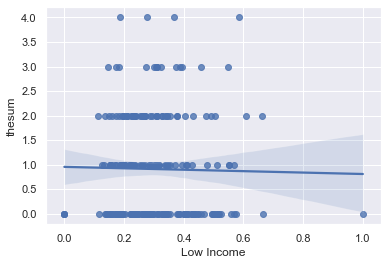

In [842]:
ax = sns.regplot(x="Low Income", y="thesum", data= Ninczip_df)

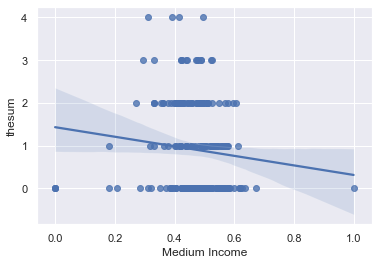

In [843]:
ax = sns.regplot(x="Medium Income", y="thesum", data= Ninczip_df)

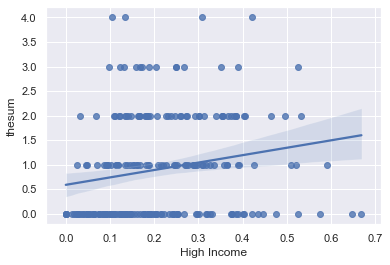

In [844]:
ax = sns.regplot(x="High Income", y="thesum", data= Ninczip_df)

Interstingly the % of low income people is not significant,  the Medium Income data has a clear log pattern and so we will use Medium Income as our feature and also high income

## Let use owner/renter Data

In [845]:
Nownzip_df= ownzip_df.copy()
Nownzip_df.head()

,Total,Owned,Rent,City,County,Land Area Km,Pop,Latitude,Longitude
Zip,,,,,,,,,
94002,10380,6308,4072,Belmont,San Mateo,12.0,25835,37.516687,-122.29026
94005,1836,1354,482,Brisbane,San Mateo,8.0,4282,37.682882,-122.40422
94010,16037,9460,6577,Burlingame,San Mateo,11.4,28806,37.574936,-122.36332
94014,14028,8169,5859,Daly City,San Mateo,19.8,101123,37.699182,-122.45035
94015,20052,11199,8853,Daly City,San Mateo,19.8,101123,37.682583,-122.48209


In [846]:
Nownzip_df['Owned Per'] = Nownzip_df['Owned'] / Nownzip_df['Total']
Nownzip_df = Nownzip_df['Owned Per']
Nownzip_df.head()

Zip
94002    0.607707
94005    0.737473
94010    0.589886
94014    0.582335
94015    0.558498
Name: Owned Per, dtype: float64

In [847]:
Nownzip_df = pd.merge(Nownzip_df, Ncombozip_df, left_index=True, right_index=True, how= 'outer')
Nownzip_df.fillna(0, inplace= True) 
Nownzip_df.head(10)

,Owned Per,Orange,yoga,crossfit,pilates,Cycle,thesum,Category
Zip,,,,,,,,
94002,0.607707,0.0,0.0,0.0,0.0,0.0,0.0,0
94005,0.737473,0.0,0.0,0.0,0.0,0.0,0.0,0
94010,0.589886,0.0,0.0,0.0,0.0,0.0,0.0,0
94014,0.582335,0.0,0.0,0.0,0.0,0.0,0.0,0
94015,0.558498,0.0,0.0,0.0,0.0,0.0,0.0,0
94019,0.699236,0.0,0.0,0.0,0.0,0.0,0.0,0
94022,0.806141,0.0,1.0,0.0,1.0,0.0,2.0,YoPi
94024,0.889611,0.0,0.0,0.0,0.0,0.0,0.0,0
94025,0.612938,0.0,1.0,0.0,0.0,0.0,1.0,Yo


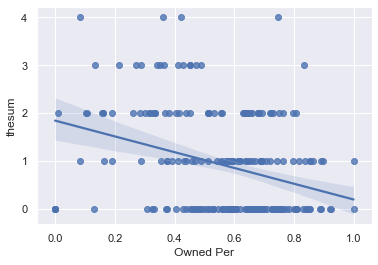

In [848]:
ax = sns.regplot(x="Owned Per", y="thesum", data= Nownzip_df)

Property Ownership seem to be significant

# Part 7 Creating our Featureset Dataframe 

In [893]:
features_df = Nagezip_df[{'City', 'Male Per','Gym Age Per','Young Kids', 'Category'}]
features_df.head(10)


,Male Per,Gym Age Per,Category,Young Kids,City
Zip,,,,,
94002,0.499228,0.485405,0,0.061613,Belmont
94005,0.471867,0.518968,0,0.046675,Brisbane
94010,0.476457,0.462368,0,0.056611,Burlingame
94014,0.502878,0.483550,0,0.047157,Daly City
94015,0.488310,0.482994,0,0.040825,Daly City
94019,0.475386,0.460274,0,0.049621,Half Moon Bay
94022,0.493033,0.417381,YoPi,0.027299,Los Altos
94024,0.471808,0.429949,0,0.044405,Los Altos
94025,0.476886,0.460246,Yo,0.077335,Menlo Park


In [894]:
# adding our commuter data

temp_df = Ncomzip_df[{'Long Commute', 'Car Per'}]
features_df = pd.merge(features_df, temp_df, left_index=True, right_index=True, how= 'outer')
features_df.head()




,Male Per,Gym Age Per,Category,Young Kids,City,Car Per,Long Commute
Zip,,,,,,,
94002,0.499228,0.485405,0,0.061613,Belmont,0.885982,0.245061
94005,0.471867,0.518968,0,0.046675,Brisbane,0.801282,0.329915
94010,0.476457,0.462368,0,0.056611,Burlingame,0.801361,0.255832
94014,0.502878,0.483550,0,0.047157,Daly City,0.711263,0.254946
94015,0.488310,0.482994,0,0.040825,Daly City,0.785084,0.220862


In [895]:
# adding our Income Data
temp_df = Ninczip_df[{'Medium Income', 'High Income'}]

features_df = pd.merge(features_df, temp_df, left_index=True, right_index=True, how= 'outer')
features_df.head()


,Male Per,Gym Age Per,Category,Young Kids,City,Car Per,Long Commute,Medium Income,High Income
Zip,,,,,,,,,
94002,0.499228,0.485405,0,0.061613,Belmont,0.885982,0.245061,0.433911,0.326108
94005,0.471867,0.518968,0,0.046675,Brisbane,0.801282,0.329915,0.453704,0.253813
94010,0.476457,0.462368,0,0.056611,Burlingame,0.801361,0.255832,0.421401,0.374571
94014,0.502878,0.483550,0,0.047157,Daly City,0.711263,0.254946,0.549401,0.110493
94015,0.488310,0.482994,0,0.040825,Daly City,0.785084,0.220862,0.563585,0.122033


In [896]:
temp_df = Nownzip_df['Owned Per']
features_df = pd.merge(features_df, temp_df, left_index=True, right_index=True, how= 'outer')
features_df.head(10)

,Male Per,Gym Age Per,Category,Young Kids,City,Car Per,Long Commute,Medium Income,High Income,Owned Per
Zip,,,,,,,,,,
94002,0.499228,0.485405,0,0.061613,Belmont,0.885982,0.245061,0.433911,0.326108,0.607707
94005,0.471867,0.518968,0,0.046675,Brisbane,0.801282,0.329915,0.453704,0.253813,0.737473
94010,0.476457,0.462368,0,0.056611,Burlingame,0.801361,0.255832,0.421401,0.374571,0.589886
94014,0.502878,0.483550,0,0.047157,Daly City,0.711263,0.254946,0.549401,0.110493,0.582335
94015,0.488310,0.482994,0,0.040825,Daly City,0.785084,0.220862,0.563585,0.122033,0.558498
94019,0.475386,0.460274,0,0.049621,Half Moon Bay,0.939937,0.234712,0.489219,0.242222,0.699236
94022,0.493033,0.417381,YoPi,0.027299,Los Altos,0.917826,0.117475,0.331752,0.532868,0.806141
94024,0.471808,0.429949,0,0.044405,Los Altos,0.939652,0.102104,0.310006,0.574761,0.889611
94025,0.476886,0.460246,Yo,0.077335,Menlo Park,0.799008,0.133657,0.377974,0.390003,0.612938


In [897]:
features_df.reset_index(level=0, inplace=True)


In [898]:
features_df = features_df.drop_duplicates()
features_df.set_index(['Zip'], inplace= True)
features_df.head(10)

,Male Per,Gym Age Per,Category,Young Kids,City,Car Per,Long Commute,Medium Income,High Income,Owned Per
Zip,,,,,,,,,,
94002,0.499228,0.485405,0,0.061613,Belmont,0.885982,0.245061,0.433911,0.326108,0.607707
94005,0.471867,0.518968,0,0.046675,Brisbane,0.801282,0.329915,0.453704,0.253813,0.737473
94010,0.476457,0.462368,0,0.056611,Burlingame,0.801361,0.255832,0.421401,0.374571,0.589886
94014,0.502878,0.483550,0,0.047157,Daly City,0.711263,0.254946,0.549401,0.110493,0.582335
94015,0.488310,0.482994,0,0.040825,Daly City,0.785084,0.220862,0.563585,0.122033,0.558498
94019,0.475386,0.460274,0,0.049621,Half Moon Bay,0.939937,0.234712,0.489219,0.242222,0.699236
94022,0.493033,0.417381,YoPi,0.027299,Los Altos,0.917826,0.117475,0.331752,0.532868,0.806141
94024,0.471808,0.429949,0,0.044405,Los Altos,0.939652,0.102104,0.310006,0.574761,0.889611
94025,0.476886,0.460246,Yo,0.077335,Menlo Park,0.799008,0.133657,0.377974,0.390003,0.612938


In [899]:
#Reorder the colums
features_df = features_df[['City','Male Per','Gym Age Per','Young Kids','Car Per', 'Long Commute', 'Medium Income', 'High Income','Owned Per', 'Category']]
features_df.head(10)

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category
Zip,,,,,,,,,,
94002,Belmont,0.499228,0.485405,0.061613,0.885982,0.245061,0.433911,0.326108,0.607707,0
94005,Brisbane,0.471867,0.518968,0.046675,0.801282,0.329915,0.453704,0.253813,0.737473,0
94010,Burlingame,0.476457,0.462368,0.056611,0.801361,0.255832,0.421401,0.374571,0.589886,0
94014,Daly City,0.502878,0.483550,0.047157,0.711263,0.254946,0.549401,0.110493,0.582335,0
94015,Daly City,0.488310,0.482994,0.040825,0.785084,0.220862,0.563585,0.122033,0.558498,0
94019,Half Moon Bay,0.475386,0.460274,0.049621,0.939937,0.234712,0.489219,0.242222,0.699236,0
94022,Los Altos,0.493033,0.417381,0.027299,0.917826,0.117475,0.331752,0.532868,0.806141,YoPi
94024,Los Altos,0.471808,0.429949,0.044405,0.939652,0.102104,0.310006,0.574761,0.889611,0
94025,Menlo Park,0.476886,0.460246,0.077335,0.799008,0.133657,0.377974,0.390003,0.612938,Yo


In [1014]:
features_df.shape

(222, 11)

## We now at last have a dataset features_df we can use to build our model

# Part: 8 K Means clustering our Data 



In [854]:
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

In [1015]:
kclusters = 4

features_clustering = features_df.drop(['City','Category'], 1)
X = features_clustering.values[:,1:]
X = np.nan_to_num(X)
features_clustering = StandardScaler().fit_transform(X)
features_clustering



array([[ 0.19553445,  0.46233979,  0.54951998, ...,  0.83509379,
         0.22092069,  0.22740259],
       [ 0.58385755, -0.39478541,  0.15838563, ...,  0.30180043,
         0.84015145, -1.00389925],
       [-0.07100475,  0.17533874,  0.15874907, ...,  1.19258901,
         0.13587922,  0.22740259],
       ...,
       [-0.55944837,  0.27463001,  0.88489223, ..., -1.26256207,
         0.52519879, -1.00389925],
       [ 0.11563529, -0.09733479,  0.92625616, ..., -1.00807787,
         0.18746192, -1.00389925],
       [-0.16691219,  0.19311317,  0.90805764, ..., -0.66470295,
         0.45118849, -1.00389925]])

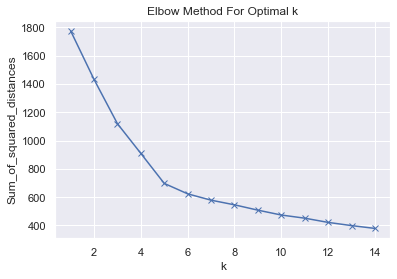

In [1016]:
# Using Elbow Method to find best Clusters
import matplotlib.pyplot as plt
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

6 clusters is optimal

In [1017]:


kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(features_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30] 

array([5, 0, 5, 0, 0, 0, 5, 5, 2, 5, 5, 0, 2, 2, 2, 0, 2, 5, 2, 5, 2, 5,
       2, 2, 2, 2, 2, 4, 4, 4], dtype=int32)

In [1365]:
#putting in cluster labels

features_df['Cluster'] = kmeans.labels_


In [1019]:
features_df.head(10)

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
Zip,,,,,,,,,,,
94002,Belmont,0.499228,0.485405,0.061613,0.885982,0.245061,0.433911,0.326108,0.607707,0,5
94005,Brisbane,0.471867,0.518968,0.046675,0.801282,0.329915,0.453704,0.253813,0.737473,0,0
94010,Burlingame,0.476457,0.462368,0.056611,0.801361,0.255832,0.421401,0.374571,0.589886,0,5
94014,Daly City,0.502878,0.483550,0.047157,0.711263,0.254946,0.549401,0.110493,0.582335,0,0
94015,Daly City,0.488310,0.482994,0.040825,0.785084,0.220862,0.563585,0.122033,0.558498,0,0
94019,Half Moon Bay,0.475386,0.460274,0.049621,0.939937,0.234712,0.489219,0.242222,0.699236,0,0
94022,Los Altos,0.493033,0.417381,0.027299,0.917826,0.117475,0.331752,0.532868,0.806141,YoPi,5
94024,Los Altos,0.471808,0.429949,0.044405,0.939652,0.102104,0.310006,0.574761,0.889611,0,5
94025,Menlo Park,0.476886,0.460246,0.077335,0.799008,0.133657,0.377974,0.390003,0.612938,Yo,2


In [1020]:
features_df.fillna(0, inplace= True) 


In [1021]:
features_df.head(20)

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
Zip,,,,,,,,,,,
94002,Belmont,0.499228,0.485405,0.061613,0.885982,0.245061,0.433911,0.326108,0.607707,0,5
94005,Brisbane,0.471867,0.518968,0.046675,0.801282,0.329915,0.453704,0.253813,0.737473,0,0
94010,Burlingame,0.476457,0.462368,0.056611,0.801361,0.255832,0.421401,0.374571,0.589886,0,5
94014,Daly City,0.502878,0.483550,0.047157,0.711263,0.254946,0.549401,0.110493,0.582335,0,0
94015,Daly City,0.488310,0.482994,0.040825,0.785084,0.220862,0.563585,0.122033,0.558498,0,0
94019,Half Moon Bay,0.475386,0.460274,0.049621,0.939937,0.234712,0.489219,0.242222,0.699236,0,0
94022,Los Altos,0.493033,0.417381,0.027299,0.917826,0.117475,0.331752,0.532868,0.806141,YoPi,5
94024,Los Altos,0.471808,0.429949,0.044405,0.939652,0.102104,0.310006,0.574761,0.889611,0,5
94025,Menlo Park,0.476886,0.460246,0.077335,0.799008,0.133657,0.377974,0.390003,0.612938,Yo,2


### Lets see how big our clusters are

In [1022]:
cluster0_df = features_df[features_df['Cluster'] == 0]
cluster0_df.shape

(85, 11)

In [1023]:
cluster1_df = features_df[features_df['Cluster'] == 1]
cluster1_df.shape

(11, 11)

In [1024]:
cluster2_df = features_df[features_df['Cluster'] == 2]
cluster2_df.shape

(48, 11)

In [1025]:
cluster3_df = features_df[features_df['Cluster'] == 3]
cluster3_df.shape

(5, 11)

In [1026]:
cluster4_df = features_df[features_df['Cluster'] == 4]
cluster4_df.shape

(34, 11)

In [1027]:
cluster5_df = features_df[features_df['Cluster'] == 5]
cluster5_df.shape

(39, 11)

### Lets try and work out what our clusters are

In [1030]:
cluster5_df.head(20)

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
Zip,,,,,,,,,,,
94002,Belmont,0.499228,0.485405,0.061613,0.885982,0.245061,0.433911,0.326108,0.607707,0,5
94010,Burlingame,0.476457,0.462368,0.056611,0.801361,0.255832,0.421401,0.374571,0.589886,0,5
94022,Los Altos,0.493033,0.417381,0.027299,0.917826,0.117475,0.331752,0.532868,0.806141,YoPi,5
94024,Los Altos,0.471808,0.429949,0.044405,0.939652,0.102104,0.310006,0.574761,0.889611,0,5
94027,Atherton,0.499060,0.380978,0.053869,0.890902,0.095411,0.208387,0.648508,0.921747,0,5
94028,Portola Valley,0.477286,0.408707,0.024898,0.935805,0.176763,0.283523,0.526150,0.808494,0,5
94062,Redwood City,0.486220,0.471521,0.050150,0.910534,0.171424,0.403201,0.401347,0.735461,0,5
94065,Redwood City,0.457588,0.531441,0.060180,0.861414,0.250545,0.469376,0.375578,0.692026,0,5
94070,San Carlos,0.483140,0.481336,0.064028,0.873135,0.216700,0.391562,0.434783,0.726843,0,5


These are the wealthy areas hign levels of high income, high car commuters and property ownership

In [1031]:
cluster3_df.head(20)

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
Zip,,,,,,,,,,,
94575,Moraga,0.324786,0.020513,0.000000,0.501144,0.041190,0.000000,0.000000,0.000000,0,3
94613,Oakland,0.030197,0.024390,0.005807,0.185185,0.051852,0.000000,0.000000,0.000000,0,3
94704,Berkeley,0.482528,0.220486,0.002501,0.255236,0.204495,0.270068,0.068392,0.106652,OrYo,3
94720,Berkeley,0.471895,0.087176,0.000000,0.076056,0.095775,0.181818,0.590909,1.000000,Yo,3
94850,Richmond,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,3


Drop the University outliers

In [ ]:
cluster3_df.drop(index=94704, inplace= True)

In [1033]:
cluster3_df.drop(index=94720, inplace= True)

In [938]:
cluster3_df.head()

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
Zip,,,,,,,,,,,
94575,Moraga,0.324786,0.020513,0.000000,0.501144,0.041190,0.0,0.0,0.0,0,3
94613,Oakland,0.030197,0.024390,0.005807,0.185185,0.051852,0.0,0.0,0.0,0,3
94850,Richmond,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,3


This is a low income bracket 

In [1034]:
cluster1_df.head(31)

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
Zip,,,,,,,,,,,
94515,Calistoga,0.507800,0.474045,0.043706,0.812462,0.110874,0.438384,0.176094,0.618855,0,1
94558,Napa,0.498930,0.436479,0.048596,0.935119,0.135504,0.522262,0.138919,0.672743,0,1
94595,Walnut Creek,0.424964,0.254934,0.028041,0.835375,0.291203,0.427607,0.148317,0.841296,0,1
95053,Santa Clara,0.464655,0.014682,0.000000,0.211392,0.021519,1.000000,0.000000,1.000000,0,1
95404,Santa Rosa,0.501260,0.454366,0.044498,0.908792,0.120331,0.482263,0.106849,0.561863,0,1
95409,Santa Rosa,0.455001,0.360757,0.038079,0.959387,0.130873,0.480946,0.115062,0.643233,0,1
95425,Cloverdale,0.475912,0.413093,0.053089,0.933580,0.160061,0.482084,0.085642,0.668615,0,1
95448,Healdsburg,0.487816,0.413168,0.036952,0.874593,0.138052,0.491078,0.166401,0.635717,YoPi,1
95472,Sebastopol,0.487777,0.434465,0.034913,0.938318,0.160749,0.518185,0.128213,0.677596,0,1


Rural areas

In [1333]:
cluster0_df.head(20)

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
Zip,,,,,,,,,,,
94005,Brisbane,0.471867,0.518968,0.046675,0.801282,0.329915,0.453704,0.253813,0.737473,0,0
94014,Daly City,0.502878,0.483550,0.047157,0.711263,0.254946,0.549401,0.110493,0.582335,0,0
94015,Daly City,0.488310,0.482994,0.040825,0.785084,0.220862,0.563585,0.122033,0.558498,0,0
94019,Half Moon Bay,0.475386,0.460274,0.049621,0.939937,0.234712,0.489219,0.242222,0.699236,0,0
94030,Millbrae,0.490401,0.476750,0.045795,0.787282,0.253980,0.481297,0.258481,0.641357,YoCy,0
94044,Pacifica,0.494381,0.485831,0.059644,0.864524,0.269096,0.578544,0.189551,0.687330,0,0
94112,San Francisco,0.499683,0.503699,0.042846,0.603633,0.295750,0.541606,0.145921,0.643041,Yo,0
94116,San Francisco,0.481463,0.480313,0.050248,0.588920,0.339522,0.491168,0.246322,0.687758,Yo,0
94124,San Francisco,0.481775,0.464469,0.061731,0.633951,0.268855,0.385472,0.098995,0.515714,0,0


 middle class longer commute

In [1335]:
cluster2_df.head(20)

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
Zip,,,,,,,,,,,
94025,Menlo Park,0.476886,0.460246,0.077335,0.799008,0.133657,0.377974,0.390003,0.612938,Yo,2
94040,Mountain View,0.527661,0.514521,0.068629,0.838405,0.099376,0.429313,0.300540,0.416505,YoCr,2
94041,Mountain View,0.531680,0.556690,0.053425,0.769920,0.092032,0.496702,0.272613,0.315327,YoCy,2
94043,Mountain View,0.532044,0.532393,0.073647,0.807185,0.106003,0.492706,0.287316,0.458001,Yo,2
94061,Redwood City,0.489602,0.495987,0.070109,0.846037,0.133657,0.481359,0.232115,0.511948,OrPi,2
94063,Redwood City,0.540475,0.495667,0.070950,0.859930,0.132877,0.453825,0.118510,0.356322,Yo,2
94066,San Bruno,0.490655,0.497635,0.054309,0.818926,0.201402,0.565003,0.175390,0.577159,0,2
94080,South San Francisco,0.490140,0.474503,0.050091,0.811770,0.204697,0.546689,0.168553,0.611866,Cr,2
94085,Sunnyvale,0.534601,0.549128,0.095333,0.857437,0.116140,0.526492,0.244349,0.373640,Cr,2


 Middle Class low commute
 

In [1037]:
cluster4_df.head(5)

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
Zip,,,,,,,,,,,
94102,San Francisco,0.571668,0.571861,0.035536,0.192003,0.210695,0.309960,0.105151,0.082843,OrYoCrPi,4
94103,San Francisco,0.584235,0.628293,0.022934,0.211000,0.193509,0.331379,0.164005,0.155650,OrCr,4
94104,San Francisco,0.681319,0.476190,0.053114,0.185185,0.236111,0.294118,0.158088,0.132353,OrYoCr,4
94105,San Francisco,0.538831,0.661824,0.058110,0.230317,0.236741,0.329666,0.524654,0.427058,OrYoCr,4
94107,San Francisco,0.526053,0.621644,0.044259,0.348836,0.265453,0.377623,0.384500,0.403409,YoCr,4


Large City Dwellers/

### Now lets look at the gym types in these clusters

In [1038]:
n_by_category = Ncombozip_df.groupby("Category")["Orange"].count()


In [1039]:
n_by_category.head(20)

Category
Cr           8
CrPi         1
Or           8
OrCr         2
OrCy         1
OrPi         1
OrYo         6
OrYoCr       5
OrYoCrPi     3
OrYoPi       2
Pi           7
PiCy         1
Yo          29
YoCr        13
YoCrCy       1
YoCrPi       4
YoCrPiCy     1
YoCy         4
YoPi        17
YoPiCy       2
Name: Orange, dtype: int64

In [1040]:
c0_by_category = cluster0_df.groupby("Category")["City"].count()
c0_by_category.head(20)

Category
0         51
Cr         3
CrPi       1
Or         5
OrYoCr     1
OrYoPi     1
Pi         2
Yo        14
YoCr       3
YoCy       2
YoPi       2
Name: City, dtype: int64

In [1041]:
c1_by_category = cluster1_df.groupby("Category")["City"].count()
c1_by_category.head(20)

Category
0       9
YoCr    1
YoPi    1
Name: City, dtype: int64

In [1042]:
c2_by_category = cluster2_df.groupby("Category")["City"].count()
c2_by_category.head(20)

Category
0         21
Cr         4
Or         1
OrCy       1
OrPi       1
OrYo       4
OrYoCr     1
Pi         1
Yo         8
YoCr       3
YoCrPi     1
YoCy       1
YoPi       1
Name: City, dtype: int64

In [1045]:
c3_by_category = cluster3_df.groupby("Category")["City"].count()
c3_by_category.head(20)

Category
0    3
Name: City, dtype: int64

In [1043]:
c4_by_category = cluster4_df.groupby("Category")["City"].count()
c4_by_category.head(20)

Category
0           4
OrCr        2
OrYo        1
OrYoCr      3
OrYoCrPi    2
OrYoPi      1
Pi          1
Yo          3
YoCr        4
YoCrCy      1
YoCrPi      3
YoCrPiCy    1
YoCy        1
YoPi        6
YoPiCy      1
Name: City, dtype: int64

In [1046]:
c5_by_category = cluster5_df.groupby("Category")["City"].count()
c5_by_category.head(20)

Category
0           18
Cr           1
Or           2
OrYoCrPi     1
Pi           3
PiCy         1
Yo           3
YoCr         2
YoPi         7
YoPiCy       1
Name: City, dtype: int64

In [1047]:
GymBreakdown_df = pd.merge(n_by_category, c0_by_category, left_index=True, right_index=True, how= 'outer')
GymBreakdown_df = pd.merge(GymBreakdown_df, c1_by_category, left_index=True, right_index=True, how= 'outer')
GymBreakdown_df = pd.merge(GymBreakdown_df, c2_by_category, left_index=True, right_index=True, how= 'outer')
GymBreakdown_df = pd.merge(GymBreakdown_df, c3_by_category, left_index=True, right_index=True, how= 'outer')
GymBreakdown_df = pd.merge(GymBreakdown_df, c4_by_category, left_index=True, right_index=True, how= 'outer')
GymBreakdown_df = pd.merge(GymBreakdown_df, c5_by_category, left_index=True, right_index=True, how= 'outer')




In [1013]:
GymBreakdown_df.head(20)

,Orange,City_x,City_y,City_x,City_y
Category,,,,,
0,NaN,51.0,4.0,19.0,28.0
Cr,8.0,3.0,NaN,1.0,4.0
CrPi,1.0,1.0,NaN,NaN,NaN
Or,8.0,5.0,NaN,2.0,1.0
OrCr,2.0,NaN,2.0,NaN,NaN
OrCy,1.0,NaN,NaN,NaN,1.0
OrPi,1.0,NaN,NaN,NaN,1.0
OrYo,6.0,NaN,1.0,NaN,4.0
OrYoCr,5.0,1.0,3.0,NaN,1.0


In [1337]:
GymBreakdown_df.columns = ['Total','Middle low commute','Rural',
                     'Middle long commute','Low Income','City','Upper Class']
GymBreakdown_df.fillna(0, inplace=True)
GymBreakdown_df = GymBreakdown_df.astype(int)
GymBreakdown_df.head(20)

,Total,Middle low commute,Rural,Middle long commute,Low Income,City,Upper Class
Category,,,,,,,
0,0,51,9,21,3,4,18
Cr,8,3,0,4,0,0,1
CrPi,1,1,0,0,0,0,0
Or,8,5,0,1,0,0,2
OrCr,2,0,0,0,0,2,0
OrCy,1,0,0,1,0,0,0
OrPi,1,0,0,1,0,0,0
OrYo,6,0,0,4,0,1,0
OrYoCr,5,1,0,1,0,3,0


In [1338]:
GymBreakdown_df.sum(axis = 0, skipna = True) 

Total                  116
Middle low commute      85
Rural                   11
Middle long commute     48
Low Income               3
City                    34
Upper Class             39
dtype: int64

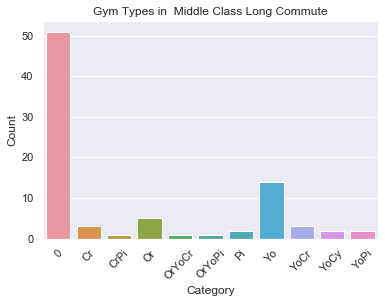

In [1363]:
tempframe = c0_by_category.to_frame()

cloplot = sns.barplot(data = c0_by_category.reset_index(), x = 'Category', y = 'City')

for item in cloplot.get_xticklabels():
    item.set_rotation(45)

cloplot.set_title('Gym Types in  Middle Class Long Commute')
cloplot.set_ylabel('Count')
    
cloplot

#sns.barplot(data = c0_by_category)



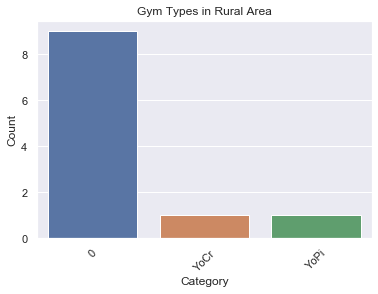

In [1102]:
tempframe = c1_by_category.to_frame()

cloplot = sns.barplot(data = c1_by_category.reset_index(), x = 'Category', y = 'City')

for item in cloplot.get_xticklabels():
    item.set_rotation(45)

cloplot.set_title('Gym Types in Rural Area')
cloplot.set_ylabel('Count')
    
cloplot

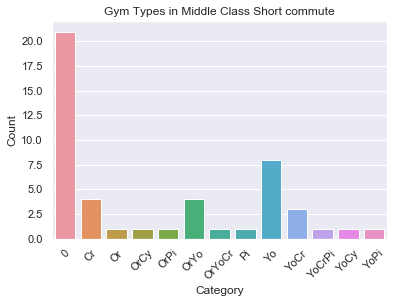

In [1368]:
tempframe = c2_by_category.to_frame()

cloplot = sns.barplot(data = c2_by_category.reset_index(), x = 'Category', y = 'City')

for item in cloplot.get_xticklabels():
    item.set_rotation(45)

cloplot.set_title('Gym Types in Middle Class Short commute')
cloplot.set_ylabel('Count')
    
cloplot

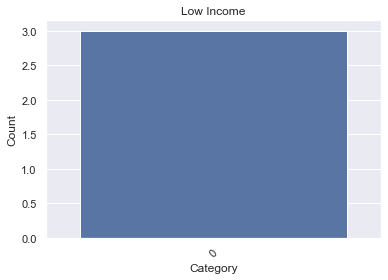

In [1105]:
tempframe = c3_by_category.to_frame()

cloplot = sns.barplot(data = c3_by_category.reset_index(), x = 'Category', y = 'City')

for item in cloplot.get_xticklabels():
    item.set_rotation(45)

cloplot.set_title('Low Income')
cloplot.set_ylabel('Count')
    
cloplot

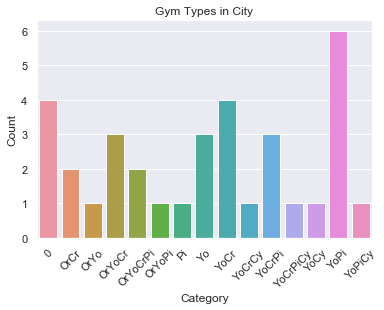

In [1107]:
tempframe = c4_by_category.to_frame()

cloplot = sns.barplot(data = c4_by_category.reset_index(), x = 'Category', y = 'City')

for item in cloplot.get_xticklabels():
    item.set_rotation(45)

cloplot.set_title('Gym Types in City')
cloplot.set_ylabel('Count')
    
cloplot

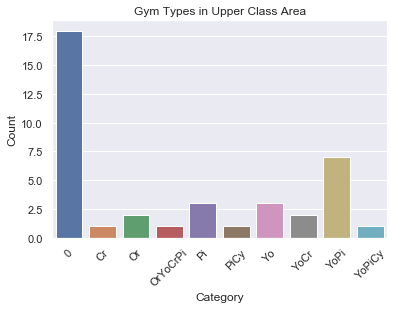

In [1108]:
tempframe = c5_by_category.to_frame()

cloplot = sns.barplot(data = c5_by_category.reset_index(), x = 'Category', y = 'City')

for item in cloplot.get_xticklabels():
    item.set_rotation(45)

cloplot.set_title('Gym Types in Upper Class Area')
cloplot.set_ylabel('Count')
    
cloplot

In [1109]:
cluster4_df.loc[(cluster4_df['Category'] == 0)]

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
Zip,,,,,,,,,,,
94128,San Francisco,0.496296,0.629630,0.000000,0.000000,0.277778,0.000000,0.000000,0.000000,0,4
94130,San Francisco,0.570170,0.402742,0.023172,0.416011,0.230164,0.388235,0.099160,0.000000,0,4
94132,San Francisco,0.476626,0.391482,0.027248,0.557584,0.316761,0.463424,0.122082,0.428794,0,4
94607,Oakland,0.491811,0.504266,0.050545,0.465914,0.253906,0.350796,0.090531,0.309027,0,4


# Part 9:  Building a Decision tree to help a potential Gym owner make the right choice in a Upper Middle Class area

In [1280]:
# we will use cluster 2 
cluster2_df.head(5)
cluster2_df.shape


(48, 11)

In [1281]:
#Create new df with only the Categorized Data

cl2clean_df = cluster2_df[(cluster2_df['Category'] != 0)]
cl2clean_df.head(5)

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
Zip,,,,,,,,,,,
94025,Menlo Park,0.476886,0.460246,0.077335,0.799008,0.133657,0.377974,0.390003,0.612938,Yo,2
94040,Mountain View,0.527661,0.514521,0.068629,0.838405,0.099376,0.429313,0.300540,0.416505,YoCr,2
94041,Mountain View,0.531680,0.556690,0.053425,0.769920,0.092032,0.496702,0.272613,0.315327,YoCy,2
94043,Mountain View,0.532044,0.532393,0.073647,0.807185,0.106003,0.492706,0.287316,0.458001,Yo,2
94061,Redwood City,0.489602,0.495987,0.070109,0.846037,0.133657,0.481359,0.232115,0.511948,OrPi,2


In [1282]:
cl2clean_df.shape

(27, 11)

### Preprocessing 

In [1283]:
# Sort out the labels on Category to make Y labels

y = cl2clean_df['Category'].values
y[0:27]


array(['Yo', 'YoCr', 'YoCy', 'Yo', 'OrPi', 'Yo', 'Cr', 'Cr', 'OrCy', 'Cr',
       'OrYo', 'OrYoCr', 'Pi', 'YoCr', 'YoCrPi', 'Yo', 'YoCr', 'OrYo',
       'Or', 'OrYo', 'Yo', 'Cr', 'OrYo', 'Yo', 'YoPi', 'Yo', 'Yo'],
      dtype=object)

In [1284]:
from sklearn import preprocessing
le_Y = preprocessing.LabelEncoder()
le_Y.fit(['Cr','Or', 'OrCy', 'OrPi', 'OrYo', 'OrYoCr', 'Pi', 'Yo', 'YoCr', 'YoCrPi', 'YoCy', 'YoPi'])
y = le_Y.transform(y) 

In [1285]:
y

array([ 7,  8, 10,  7,  3,  7,  0,  0,  2,  0,  4,  5,  6,  8,  9,  7,  8,
        4,  1,  4,  7,  0,  4,  7, 11,  7,  7])

In [1286]:
# Lets create a dataframe to more easily reference this 

Category_df = pd.DataFrame({'x':cl2clean_df['Category'].values, 'y':y})
Category_df = Category_df.drop_duplicates()
Category_df.columns= ['Category', 'CatCode']
Category_df.set_index('Category', inplace=True)

#Category_df.set_index('x', inplace=True)
#category = Category_df.unique

Category_df.head(28)

,CatCode
Category,
Yo,7
YoCr,8
YoCy,10
OrPi,3
Cr,0
OrCy,2
OrYo,4
OrYoCr,5
Pi,6


In [1287]:
#Grab our X Data
X = cl2clean_df[{'Male Per','Gym Age Per', 'Young Kids' , 'Car Per', 'Long Commute', 'Medium Income', 'High Income', 'Owned Per'}].values
X = preprocessing.StandardScaler().fit(X).transform(X)

X[0:5]



array([[-1.35208491, -0.43711028,  1.11031554, -1.13632804,  0.86139803,
        -1.86148567,  1.94358884, -0.91154705],
       [ 0.73383884, -1.132029  , -0.35709063,  0.312804  ,  0.02122521,
        -0.91795762,  0.90920714, -0.23387886],
       [ 0.89895146, -1.28090728, -1.11292213,  1.43871997, -1.44602484,
         0.32053471,  0.58631122, -1.41189712],
       [ 0.91390884, -0.99770112, -0.04710776,  0.78999477,  0.50551786,
         0.2470863 ,  0.75630574, -0.7709023 ],
       [-0.82967803, -0.43710451,  0.35589127, -0.18203892,  0.16407342,
         0.03854996,  0.1180612 , -0.10260577]])

### Preparing our Test and training datasets

In [1288]:
from sklearn.model_selection import train_test_split


In [1289]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

In [1290]:
print(X_trainset.shape)
print(y_trainset.shape)

(18, 8)
(18,)


In [1291]:
print(X_testset.shape)
print(y_testset.shape)

(9, 8)
(9,)


### Modeling

In [1292]:
from sklearn.tree import DecisionTreeClassifier
GymTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
GymTree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [1293]:
GymTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [1294]:
predTree = GymTree.predict(X_testset)

In [1295]:
print (predTree [0:5])
print (y_testset [0:5])

[4 3 0 0 0]
[1 4 6 7 7]


In [1296]:
Category_df.head(28)

,CatCode
Category,
Yo,7
YoCr,8
YoCy,10
OrPi,3
Cr,0
OrCy,2
OrYo,4
OrYoCr,5
Pi,6


In [1297]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.0


## Total Fail!!   


# Part 10:  Lets try with entire Data Set

In [1189]:
features_df.head(10)
features_df.shape


(222, 11)

In [1192]:
featuresclean_df = features_df[(features_df['Category'] != 0)]
featuresclean_df.shape

(116, 11)

In [1194]:
y = featuresclean_df['Category'].values
y[0:116]

array(['YoPi', 'Yo', 'YoCy', 'YoCr', 'YoCy', 'Yo', 'OrPi', 'Yo', 'Cr',
       'Cr', 'OrCy', 'Cr', 'OrYoCrPi', 'OrCr', 'OrYoCr', 'OrYoCr', 'YoCr',
       'OrCr', 'YoCr', 'YoCrPiCy', 'OrYoCr', 'Yo', 'YoPiCy', 'OrYoPi',
       'Yo', 'YoPi', 'YoCrPi', 'YoPi', 'Pi', 'YoPi', 'YoPi', 'YoCr',
       'YoPi', 'YoPi', 'YoPi', 'OrYo', 'YoCr', 'OrYoCr', 'Pi', 'Or', 'Yo',
       'Cr', 'Yo', 'CrPi', 'Or', 'YoPi', 'YoPiCy', 'Pi', 'Yo', 'Yo',
       'OrYoCrPi', 'Cr', 'Yo', 'Or', 'YoPi', 'Yo', 'Yo', 'Or', 'YoCr',
       'Yo', 'Yo', 'OrYoCr', 'Pi', 'YoCr', 'Yo', 'Yo', 'YoCrPi', 'YoCrPi',
       'YoPi', 'Yo', 'YoPi', 'Yo', 'YoCr', 'OrYoCrPi', 'OrYo', 'Yo',
       'OrYoPi', 'Or', 'Or', 'YoCy', 'YoCrCy', 'Yo', 'Cr', 'YoCrPi', 'Pi',
       'Yo', 'Yo', 'Pi', 'YoPi', 'YoCr', 'YoCy', 'YoPi', 'YoCr', 'YoCr',
       'Yo', 'PiCy', 'YoPi', 'YoCr', 'OrYo', 'Or', 'OrYo', 'Yo', 'OrYo',
       'Yo', 'Cr', 'OrYo', 'Yo', 'YoPi', 'Yo', 'Cr', 'Or', 'Yo', 'Pi',
       'Yo', 'YoPi', 'YoCr'], dtype=object)

In [1203]:
le_Y = preprocessing.LabelEncoder()
le_Y.fit(['Cr','Or', 'OrCy', 'OrPi', 'OrYo', 'OrYoCr', 'Pi', 'Yo', 'YoCr', 'YoCrPi', 'YoCy', 'YoPi', 'OrYoCrPi', 'OrCr', 'YoCrPiCy', 'YoPiCy', 'OrYoPi', 'CrPi', 'YoCrCy', 'PiCy'])
y = le_Y.transform(y) 


In [1204]:
y

array([18, 12, 17, 13, 17, 12,  5, 12,  0,  0,  4,  0,  8,  3,  7,  7, 13,
        3, 13, 16,  7, 12, 19,  9, 12, 18, 15, 18, 10, 18, 18, 13, 18, 18,
       18,  6, 13,  7, 10,  2, 12,  0, 12,  1,  2, 18, 19, 10, 12, 12,  8,
        0, 12,  2, 18, 12, 12,  2, 13, 12, 12,  7, 10, 13, 12, 12, 15, 15,
       18, 12, 18, 12, 13,  8,  6, 12,  9,  2,  2, 17, 14, 12,  0, 15, 10,
       12, 12, 10, 18, 13, 17, 18, 13, 13, 12, 11, 18, 13,  6,  2,  6, 12,
        6, 12,  0,  6, 12, 18, 12,  0,  2, 12, 10, 12, 18, 13])

In [1208]:
Category_df = pd.DataFrame({'x':featuresclean_df['Category'].values, 'y':y})
Category_df = Category_df.drop_duplicates()
Category_df.columns= ['Category', 'CatCode']
Category_df.set_index('Category', inplace=True)
Category_df.sort_values(by=['CatCode'], inplace=True)

#Category_df.set_index('x', inplace=True)
#category = Category_df.unique

Category_df.head(28)

,CatCode
Category,
Cr,0
CrPi,1
Or,2
OrCr,3
OrCy,4
OrPi,5
OrYo,6
OrYoCr,7
OrYoCrPi,8


In [1258]:
#Grab our X Data
X = featuresclean_df[{'Male Per','Gym Age Per', 'Young Kids' , 'Car Per', 'Long Commute', 'Medium Income', 'High Income', 'Owned Per'}].values
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.17225058, -1.62450368,  1.35026824, -1.04029412, -1.58781735,
        -1.7209126 ,  2.39559331,  0.9259757 ],
       [-0.68270747, -1.42827135,  0.43850132, -0.42767299,  1.46075727,
        -1.11469385,  1.22202963,  0.40347955],
       [-0.25547476,  0.03083741,  0.57261804, -0.19179505, -0.46090665,
         0.24042645,  0.14165239,  0.35191404],
       [ 0.92241009, -1.84397667, -0.48850558,  0.34801233,  0.93032206,
        -0.44136183,  0.48714141,  0.57672528],
       [ 1.04946418, -1.93303672, -0.96598824,  0.95068789,  0.00398755,
         0.44246621,  0.25773634,  0.27556515]])

In [1259]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

In [1260]:
print(X_trainset.shape)
print(y_trainset.shape)

(81, 8)
(81,)


In [1261]:
print(X_testset.shape)
print(y_testset.shape)

(35, 8)
(35,)


In [1262]:
GymTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
GymTree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [1263]:
GymTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [1264]:
predTree = GymTree.predict(X_testset)

In [1265]:
print (predTree [0:5])
print (y_testset [0:5])

[ 7 13 18  8 12]
[15 12  5 12  6]


In [1266]:
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.14285714285714285


## Lets see if SVM works better

In [1267]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_trainset, y_trainset) 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [1268]:
yhat = clf.predict(X_testset)
print (yhat [0:5])
print (y_testset [0:5])

[12 12 12 18 12]
[15 12  5 12  6]


In [1269]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, yhat))

DecisionTrees's Accuracy:  0.3142857142857143


## Logistical Regression maybe?

In [1254]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_trainset,y_trainset)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [1271]:
yhat = LR.predict(X_testset)

array([12, 12, 12, 12, 12, 12, 12, 13, 12, 12, 12, 12, 12, 12,  3, 12, 12,
        3, 12, 18, 11, 12, 12, 18, 12, 12, 12, 12, 12, 12, 12,  3, 12, 12,
        3])

In [1272]:
print (yhat [0:5])
print (y_testset [0:5])

[12 12 12 12 12]
[15 12  5 12  6]


In [1274]:
print("Logistical Regression: ", metrics.accuracy_score(y_testset, yhat))

Logistical Regression:  0.3142857142857143


# Part 11:  Lets apply this SVM model to our Upper Middle Class area and help the Gym owner pick a type of Gym for each area

In [1311]:
cluster2_df.head(5)


cl2zero_df = cluster2_df[(cluster2_df['Category'] == 0)]
cl2zero_df.head(5)

,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
Zip,,,,,,,,,,,
94066,San Bruno,0.490655,0.497635,0.054309,0.818926,0.201402,0.565003,0.175390,0.577159,0,2
94089,Sunnyvale,0.539103,0.543764,0.065657,0.916102,0.100032,0.510431,0.221948,0.606468,0,2
94304,Palo Alto,0.499744,0.463352,0.067914,0.509650,0.050663,0.544173,0.294851,0.130623,0,2
94559,Napa,0.510736,0.455873,0.064237,0.905991,0.124885,0.499951,0.088728,0.491137,0,2
94603,Oakland,0.486457,0.455612,0.088804,0.834635,0.230261,0.405313,0.018079,0.458540,0,2


In [1312]:
cl2zero_df.shape

(21, 11)

In [1313]:
X = cl2zero_df[{'Male Per','Gym Age Per', 'Young Kids' , 'Car Per', 'Long Commute', 'Medium Income', 'High Income', 'Owned Per'}].values
X = preprocessing.StandardScaler().fit(X).transform(X)

X[0:5]


array([[-5.97930549e-01,  8.14411176e-01,  5.48156280e-01,
         7.14169491e-01, -1.20976037e+00,  1.45128825e+00,
         3.45641913e-01, -7.10050317e-01],
       [ 2.59608525e+00, -1.26139330e+00,  7.74378847e-01,
         2.17598871e+00, -2.33214803e-01,  4.08421970e-01,
         8.33478462e-01,  3.16236087e-01],
       [ 1.26929280e-03, -2.27235025e+00, -2.89846242e+00,
        -3.72239654e-01, -3.89864146e-02,  1.05323808e+00,
         1.59736119e+00, -3.97633587e+00],
       [ 7.25986410e-01, -7.52466444e-01, -1.15813619e-01,
        -6.09243237e-01, -3.55375314e-01,  2.08155144e-01,
        -5.62409917e-01,  2.09457713e-01],
       [-8.74695103e-01,  1.40538986e+00, -3.67419324e-01,
        -6.17509920e-01,  1.75866256e+00, -1.60036981e+00,
        -1.30267321e+00, -5.44143012e-01]])

In [1314]:
yhat2 = clf.predict(X)

In [1315]:
print (yhat2 [0:5])

[18 18 12 12 12]


In [1321]:
yhat2_df = pd.DataFrame(yhat2)
yhat2_df.shape

(21, 1)

In [1330]:
Ncl2zero_df = cl2zero_df.copy()
Ncl2zero_df.reset_index(inplace= True)
Ncl2zero_df.head()

,Zip,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster
0,94066,San Bruno,0.490655,0.497635,0.054309,0.818926,0.201402,0.565003,0.175390,0.577159,0,2
1,94089,Sunnyvale,0.539103,0.543764,0.065657,0.916102,0.100032,0.510431,0.221948,0.606468,0,2
2,94304,Palo Alto,0.499744,0.463352,0.067914,0.509650,0.050663,0.544173,0.294851,0.130623,0,2
3,94559,Napa,0.510736,0.455873,0.064237,0.905991,0.124885,0.499951,0.088728,0.491137,0,2
4,94603,Oakland,0.486457,0.455612,0.088804,0.834635,0.230261,0.405313,0.018079,0.458540,0,2


In [1331]:

Ncl2zero_df = pd.concat([Ncl2zero_df, yhat2_df], axis=1)

Ncl2zero_df.shape

(21, 13)

In [1332]:
Ncl2zero_df.head(22)

,Zip,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster,0
0,94066,San Bruno,0.490655,0.497635,0.054309,0.818926,0.201402,0.565003,0.175390,0.577159,0,2,18
1,94089,Sunnyvale,0.539103,0.543764,0.065657,0.916102,0.100032,0.510431,0.221948,0.606468,0,2,18
2,94304,Palo Alto,0.499744,0.463352,0.067914,0.509650,0.050663,0.544173,0.294851,0.130623,0,2,12
3,94559,Napa,0.510736,0.455873,0.064237,0.905991,0.124885,0.499951,0.088728,0.491137,0,2,12
4,94603,Oakland,0.486457,0.455612,0.088804,0.834635,0.230261,0.405313,0.018079,0.458540,0,2,12
5,94621,Oakland,0.480035,0.426276,0.099895,0.771786,0.249243,0.320142,0.014684,0.325245,0,2,12
6,94928,Rohnert Park,0.471691,0.423985,0.071333,0.931095,0.168744,0.514189,0.039130,0.527441,0,2,12
7,95035,Milpitas,0.510637,0.506047,0.066218,0.935689,0.175901,0.520363,0.244887,0.648140,0,2,18
8,95051,Santa Clara,0.516078,0.516112,0.071572,0.904446,0.126306,0.536081,0.239686,0.485516,0,2,18
9,95111,San Jose,0.500849,0.454770,0.074272,0.931465,0.215203,0.487043,0.080910,0.590065,0,2,12


In [1343]:
Zip_df.head(5)

,City,County,Land Area Km,Pop,Latitude,Longitude
Zip,,,,,,
94501,Alameda,Alameda,27.5,73812,37.769528,-122.25937
94502,Alameda,Alameda,27.5,73812,37.734379,-122.23952
94706,Albany,Alameda,4.6,18539,37.889125,-122.29371
94503,American Canyon,Napa,12.5,19454,38.170372,-122.25605
94509,Antioch,Contra Costa,73.4,102372,37.991571,-121.80207


In [1355]:
Ncl2zero_df.set_index(Ncl2zero_df['Zip'], inplace=True)
Ncl2zero_df.head()

,Zip,City,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster,0
Zip,,,,,,,,,,,,,
94066,94066,San Bruno,0.490655,0.497635,0.054309,0.818926,0.201402,0.565003,0.175390,0.577159,0,2,18
94089,94089,Sunnyvale,0.539103,0.543764,0.065657,0.916102,0.100032,0.510431,0.221948,0.606468,0,2,18
94304,94304,Palo Alto,0.499744,0.463352,0.067914,0.509650,0.050663,0.544173,0.294851,0.130623,0,2,12
94559,94559,Napa,0.510736,0.455873,0.064237,0.905991,0.124885,0.499951,0.088728,0.491137,0,2,12
94603,94603,Oakland,0.486457,0.455612,0.088804,0.834635,0.230261,0.405313,0.018079,0.458540,0,2,12


In [1356]:
final_df = pd.merge(Ncl2zero_df, Zip_df, left_index=True, right_index=True )

finalyopi = final_df[(final_df[0] == 18)]
finalyoga = final_df[(final_df[0] == 12)]

finalyoga.head(5)


,Zip,City_x,Male Per,Gym Age Per,Young Kids,Car Per,Long Commute,Medium Income,High Income,Owned Per,Category,Cluster,0,City_y,County,Land Area Km,Pop,Latitude,Longitude
Zip,,,,,,,,,,,,,,,,,,,
94304,94304,Palo Alto,0.499744,0.463352,0.067914,0.509650,0.050663,0.544173,0.294851,0.130623,0,2,12,Palo Alto,Santa Clara,61.8,64403,37.397823,-122.16605
94559,94559,Napa,0.510736,0.455873,0.064237,0.905991,0.124885,0.499951,0.088728,0.491137,0,2,12,Napa,Napa,46.2,76915,38.291164,-122.28671
94603,94603,Oakland,0.486457,0.455612,0.088804,0.834635,0.230261,0.405313,0.018079,0.458540,0,2,12,Oakland,Alameda,144.5,390724,37.738379,-122.17332
94621,94621,Oakland,0.480035,0.426276,0.099895,0.771786,0.249243,0.320142,0.014684,0.325245,0,2,12,Oakland,Alameda,144.5,390724,37.753978,-122.18969
94928,94928,Rohnert Park,0.471691,0.423985,0.071333,0.931095,0.168744,0.514189,0.039130,0.527441,0,2,12,Rohnert Park,Sonoma,18.1,40971,38.347174,-122.69537


In [1360]:
# create map of Bay Area using latitude and longitude values
map_bay2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers for Yoga  
    
for lat, lng, city in zip(finalyoga['Latitude'], finalyoga['Longitude'], finalyoga['City_x']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='green', prefix= 'fa' , icon = 'circle')).add_to(map_bay2)  
    

# add markers to map for Orange Theory
for lat, lng, city in zip(finalyopi['Latitude'], finalyopi['Longitude'], finalyopi['City_x']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label,
        icon=folium.Icon(color='blue', prefix= 'fa' , icon = 'circle')).add_to(map_bay2)  
    

legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 200px; height: 70px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">
                              &nbsp; Yoga Studio &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                              &nbsp; Yoga or Pilates Studio &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
                              
                </div>
                ''' 
map_bay2.get_root().html.add_child(folium.Element(legend_html))
    
map_bay2